# Defining an Aperture

## Introduction

In this tutorial we will define apertures, starting from a simple one and increasing the complexity.

The aperture can be a simple circular one, or with an obscuration and even with spiders to hold the secondary mirror in place. The Amplitude (through the aperture) simply describes how much light is let in, therefore it is the Amplitude at each point on the aperture.

The aperture definition is handled by [`prysm`](https://prysm.readthedocs.io).

## Loading the Optics Parameters

We have to start with the opticks package import.

In [ ]:
# If opticks import fails, try to locate the module
# This can happen building the docs
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", ".."))
    os.getcwd()

In [184]:
from opticks import u

# pint support to matplotlib
u.setup_matplotlib()

In [185]:
from pathlib import Path

from opticks.imager_model.optics import Optics

# print(f"current working directory: {Path.cwd()}")

file_directory = Path("docs", "examples", "sample_sat_pushbroom")
optics_file_path = file_directory.joinpath("optics.yaml")

# check whether input files exist
print(
    f"optics file:  [{optics_file_path}] (file exists:  {optics_file_path.is_file()})"
)


# Init optics object
optics = Optics.from_yaml_file(optics_file_path)

optics file:  [docs/examples/sample_sat_pushbroom/optics.yaml] (file exists:  True)


## A Simple Circular Aperture

Now that the optics data is loaded, we have to define the aperture. For this example we will start with the Pléiades optics.

Pléiades has an optical diameter of 650 mm and we can define a simple circular aperture.

aperture diameter: 650 mm
aperture samples: 400
aperture sample spacing: 1.625 mm


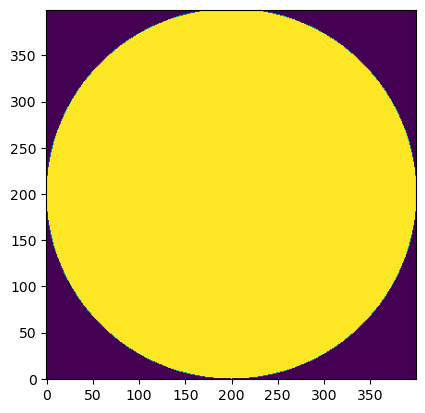

In [186]:
from opticks.imager_model.optics import ApertureFactory

%matplotlib inline

from matplotlib import pyplot as plt

# Generate the aperture model
# ---------------------------
# aperture sample size (per side)
samples = 400
# generate the grid and the aperture
# r in mm and t in radians
aperture, r,t = ApertureFactory.circle_aperture(optics.params.aperture_diameter, samples, with_units=True)

# set the aperture in the Optics model
optics.set_aperture_model(aperture)

print(f"aperture diameter: {optics.params.aperture_diameter:~P}")
print(f"aperture samples: {samples}")
# sample spacing of the aperture definition
# implicitly assumes samples is int and not (int, int)
print(f"aperture sample spacing: {optics.aperture_dx:~P}")

# visualise the aperture model
# also possible to initialise a RichData object and use plot2d()
plt.imshow(aperture, origin="lower", aspect="equal")

The aperture model is simply an `ndarray` mask that is `True` or `False` for each "sample" of the aperture, depending on whether the light can pass or not. It can also be expressed as an `ndarray` of floats (0.0 and 1.0).

## Circular Aperture with Obscuration

However, this aperture is not very realistic, as Pléiades has a 30% centre obscuration due to the secondary mirror. Now let's define this aperture.

Also note the use of the `extent` keyword to map the aperture onto real dimensions.

aperture diameter: 650 mm
aperture samples: 400
aperture sample spacing: 1.625 mm


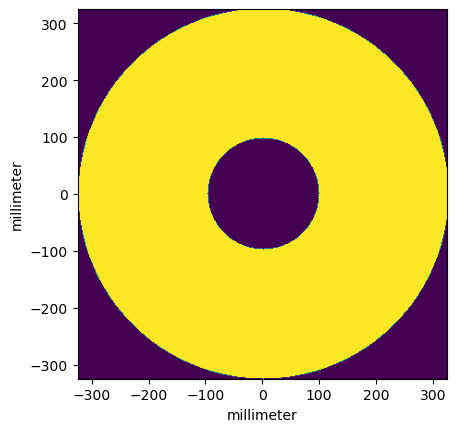

In [187]:
# 30% obscuration for Pléiades
obscuration_ratio = 0.3

# generate the grid and the aperture
# r in mm and t in radians
aperture, r,t = ApertureFactory.circle_aperture_with_obscuration(optics.params.aperture_diameter, obscuration_ratio, samples, with_units=True)

# set the aperture in the Optics model
optics.set_aperture_model(aperture)

print(f"aperture diameter: {optics.params.aperture_diameter:~P}")
print(f"aperture samples: {samples}")
# sample spacing of the aperture definition
# implicitly assumes samples is int and not (int, int)
print(f"aperture sample spacing: {optics.aperture_dx:~P}")

half_ext = optics.params.aperture_diameter/2
# visualise the aperture model
# the extent values map the image to real dimensions
# also possible to initialise a RichData object and use plot2d()
plt.imshow(aperture, origin="lower", aspect="equal", extent=[-half_ext, half_ext, -half_ext, half_ext])

To make this even more realistic, we will add three spiders. Note that the polar grid that we have generated earlier cannot be used directly for the spiders. We either have to generate a new rectilinear grid, or we can convert the polar grid into a rectilinear grid using `prysm.coordinates.polar_to_cart()`.

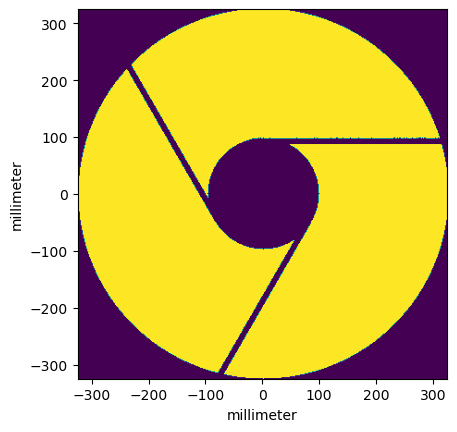

In [188]:
from prysm.geometry import spider
from prysm.coordinates import make_xy_grid

# import numpy as np

# print(optics.params.aperture_diameter / 2 * obscuration_ratio * np.cos(240 * u.deg))
# print(optics.params.aperture_diameter / 2 * obscuration_ratio * np.sin(240 * u.deg))

leg_width = 10 * u.mm

x, y = make_xy_grid(samples, dx=optics.aperture_dx)
spider_leg_1 = spider(1, leg_width, x, y, rotation=0 * u.deg, center=(-20, 92.5) * u.mm)
spider_leg_2 = spider(
    1, leg_width, x, y, rotation=120 * u.deg, center=(-84.43+5, -48.75) * u.mm
)
spider_leg_3 = spider(
    1, leg_width, x, y, rotation=240 * u.deg, center=(84.43-5, -48.75) * u.mm
)

aperture = aperture & spider_leg_1 & spider_leg_2 & spider_leg_3


plt.imshow(
    aperture,
    origin="lower",
    aspect="equal",
    extent=[-half_ext, half_ext, -half_ext, half_ext],
)

## Rectangular Aperture (with `prysm`)

For the previous examples we have shown the wrapper `ApertureFactory` in action, but the aperture definitions from `prysm` can be used for other shapes. There are a lot of interesting examples [here](https://prysm.readthedocs.io/en/stable/how-tos/Notable-Telescope-Apertures.html).

For this example we will define a rectangular aperture with a width of 500 m and aspect ratio of 0.4.

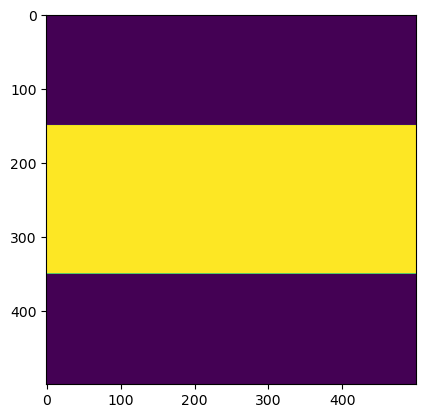

In [189]:
from prysm.coordinates import make_xy_grid
from prysm.geometry import rectangle

# aperture grid definition
sample_size = 500
sample_distance = 1 # in mm

aperture_aspect_ratio = 0.4

# generate aperture grid
x, y = make_xy_grid(sample_size, dx=sample_distance)

width = int(sample_size / 2)
height = int(width * aperture_aspect_ratio)

# create aperture opening
mask_out= rectangle(width, x, y, height=height, angle=0)

mask  = mask_out
plt.imshow(mask)